In [243]:
# import project Libraries 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [244]:
# Load the data and create pandas DataFrame. 
df = pd.read_csv('./My_data/Food_enforcement_data.csv',encoding= 'unicode_escape')

In [245]:
# Exploring the summary of our DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20677 entries, 0 to 20676
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   FEI_Number              20677 non-null  object
 1   Product ID              20677 non-null  int64 
 2   Recalling_Firm          20677 non-null  object
 3   Product_Type            20677 non-null  object
 4   Status                  20677 non-null  object
 5   Recalling_Firm_City     20677 non-null  object
 6   Recalling_Firm_State    20677 non-null  object
 7   Recalling_Firm_Country  20677 non-null  object
 8   Classification_Date     20677 non-null  object
 9   Recall_Reason           20677 non-null  object
 10  Product_Description     20677 non-null  object
 11  Classification          20677 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.9+ MB


In [246]:
# get columns names( this works as week refrence once i start dropping columns not needed)
df.columns

Index(['FEI_Number', 'Product ID', 'Recalling_Firm', 'Product_Type', 'Status',
       'Recalling_Firm_City', 'Recalling_Firm_State', 'Recalling_Firm_Country',
       'Classification_Date', 'Recall_Reason', 'Product_Description',
       'Classification'],
      dtype='object')

In [247]:
# To identify any missing data (null value) and deal with with it. 
df.isnull().sum()

FEI_Number                0
Product ID                0
Recalling_Firm            0
Product_Type              0
Status                    0
Recalling_Firm_City       0
Recalling_Firm_State      0
Recalling_Firm_Country    0
Classification_Date       0
Recall_Reason             0
Product_Description       0
Classification            0
dtype: int64

In [248]:
from sklearn.preprocessing import LabelEncoder



In [249]:
# LabelEncoder is used when Encoding Categorical features to numerical. 
label_encode = LabelEncoder()

In [250]:
df["Classification"] = label_encode.fit_transform(df['Classification'].astype('str'))

In [251]:
# Source: https://maxhalford.github.io/blog/target-encoding-done-the-right-way/
def calc_smooth_mean(df1, df2, cat_name, target, weight):
    # Compute the global mean
    mean = df[target].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(cat_name)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + weight * mean) / (counts + weight)

    # Replace each value by the according smoothed mean
    if df2 is None:
        return df1[cat_name].map(smooth)
    else:
        return df1[cat_name].map(smooth),df2[cat_name].map(smooth.to_dict())


WEIGHT = 5
df['Recall_Reason'] = calc_smooth_mean(df1=df, df2=None, cat_name='Recall_Reason', target='Classification', weight=WEIGHT)
df['Product_Description'] = calc_smooth_mean(df1=df, df2=None, cat_name='Product_Description', target='Classification', weight=WEIGHT)

In [252]:
import category_encoders as ce

In [253]:
# here we are encoding "Classification column" which has ordinal data (ClassI, Class II, Class III)
# Using LabelEncoder technique. 
encode = ce.OneHotEncoder(cols='Classification',handle_unknown='return_nan',return_df=True,use_cat_names=True)
data_encoded = encode.fit_transform(df)

In [254]:
# Here we are Encoding 'Recalling_Firm_City' Column using binary Encoding technique
encode_0 = ce.BinaryEncoder(cols=['Recalling_Firm_City'],return_df=True)
data_encoded = encode_0.fit_transform(data_encoded)

In [255]:
# encoding column "status" using One-Hot-Encode method
enoder_1 = ce.OneHotEncoder(cols='Status',handle_unknown='return_nan',return_df=True,use_cat_names=True)

In [256]:
# Trnsforming the encoded data. 
data_encoded = enoder_1.fit_transform(data_encoded)

In [257]:
# Here we are Encoding 'Recalling_Firm_Country' Column using binary Encoding technique
encoder_2 = ce.BinaryEncoder(cols=['Recalling_Firm_Country'],return_df=True)

In [258]:
# Trnsforming the encoded data. 
data_encoded = encoder_2.fit_transform(data_encoded)

In [259]:
# drop unwanted columns 
data_encoded = data_encoded.drop('Recalling_Firm_State',axis=1)

In [260]:
data_encoded = data_encoded.drop('Product_Type',axis=1)


data_encoded = data_encoded.drop('Recalling_Firm',axis=1)
data_encoded = data_encoded.drop('Product ID',axis=1)
data_encoded = data_encoded.drop('FEI_Number',axis=1)
data_encoded = data_encoded.drop('Classification_Date',axis=1)

In [261]:
X = data_encoded.iloc[:,:23].values
y = data_encoded.iloc[:,23:].values

In [262]:
from sklearn.model_selection import train_test_split

In [263]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [264]:
from sklearn.preprocessing import MinMaxScaler

In [265]:
scaler = MinMaxScaler()

In [266]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [267]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [268]:
model = Sequential()
model.add(Dense(24, input_dim=23, activation='relu',
                kernel_initializer='random_normal'))
model.add(Dense(12,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(6,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)

In [269]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Train on 15507 samples, validate on 5170 samples
Epoch 1/1000
15507/15507 - 2s - loss: 0.8881 - accuracy: 0.5253 - val_loss: 0.8110 - val_accuracy: 0.6174
Epoch 2/1000
15507/15507 - 1s - loss: 0.4008 - accuracy: 0.8887 - val_loss: 0.2152 - val_accuracy: 0.9329
Epoch 3/1000
15507/15507 - 1s - loss: 0.1403 - accuracy: 0.9459 - val_loss: 0.0526 - val_accuracy: 0.9892
Epoch 4/1000
15507/15507 - 1s - loss: 0.0290 - accuracy: 0.9939 - val_loss: 0.0137 - val_accuracy: 0.9977
Epoch 5/1000
15507/15507 - 1s - loss: 0.0102 - accuracy: 0.9983 - val_loss: 0.0058 - val_accuracy: 0.9994
Epoch 6/1000
15507/15507 - 1s - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.0032 - val_accuracy: 0.9996
Epoch 7/1000
15507/15507 - 1s - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 8/1000
15507/15507 - 1s - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0014 - val_accuracy: 0.9998
Epoch 9/1000
15507/15507 - 1s - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0010 - val_accuracy: 0.99

In [270]:
df_loss = pd.DataFrame(model.history.history)
df_loss

,loss,accuracy,val_loss,val_accuracy
0,0.888104,0.525311,0.811019,0.617408
1,0.400807,0.888695,0.215167,0.932882
2,0.140277,0.945895,0.052590,0.989168
3,0.028960,0.993874,0.013717,0.997679
4,0.010222,0.998259,0.005759,0.999420
5,0.004830,0.999355,0.003180,0.999613
6,0.002727,0.999742,0.001863,0.999613
7,0.001829,0.999742,0.001418,0.999807
8,0.001641,0.999678,0.001045,0.999613
9,0.001196,0.999871,0.000654,0.999613


<AxesSubplot:>

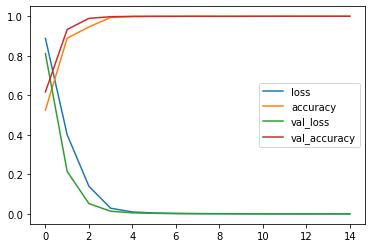

In [271]:
df_loss.plot()

In [272]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

In [273]:
from sklearn import metrics

y_compare = np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.9996131528046421


In [274]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[2167    1    0]
 [   0 2714    1]
 [   0    0  287]]
Normalized confusion matrix
[[1.00e+00 4.61e-04 0.00e+00]
 [0.00e+00 1.00e+00 3.68e-04]
 [0.00e+00 0.00e+00 1.00e+00]]


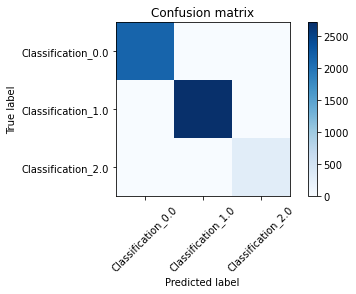

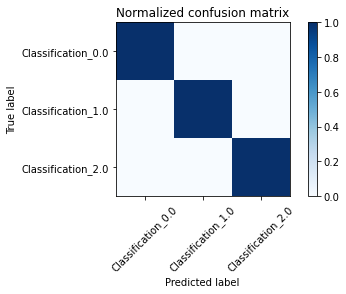

In [275]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
My_products = pd.DataFrame(data_encoded.iloc[:,23:])
products = My_products.columns
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, products)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, 
        title='Normalized confusion matrix')

plt.show()

In [276]:
pred[:30]

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       2, 1, 0, 1, 0, 0, 0, 0])

In [277]:
model.evaluate(X_test,y_test,verbose=0)

[0.0006539302394406534, 0.99961317]

In [278]:
epochs = len(df_loss)

In [279]:
scaled_X = scaler.fit_transform(X)

In [280]:
model = Sequential()
model.add(Dense(X.shape[1],input_dim=23, activation='relu',
                kernel_initializer='random_normal'))
model.add(Dense(12,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(6,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)

In [281]:
model.fit(scaled_X,y,validation_data=(X_test,y_test),callbacks=[monitor],verbose=2,epochs=500)

Train on 20677 samples, validate on 5170 samples
Epoch 1/500
20677/20677 - 3s - loss: 0.8791 - accuracy: 0.5195 - val_loss: 0.8392 - val_accuracy: 0.5251
Epoch 2/500
20677/20677 - 1s - loss: 0.6277 - accuracy: 0.7016 - val_loss: 0.3582 - val_accuracy: 0.9331
Epoch 3/500
20677/20677 - 1s - loss: 0.2667 - accuracy: 0.9323 - val_loss: 0.2012 - val_accuracy: 0.9377
Epoch 4/500
20677/20677 - 1s - loss: 0.1676 - accuracy: 0.9371 - val_loss: 0.1353 - val_accuracy: 0.9408
Epoch 5/500
20677/20677 - 1s - loss: 0.1161 - accuracy: 0.9403 - val_loss: 0.0959 - val_accuracy: 0.9443
Epoch 6/500
20677/20677 - 1s - loss: 0.0826 - accuracy: 0.9548 - val_loss: 0.0688 - val_accuracy: 0.9996
Epoch 7/500
20677/20677 - 1s - loss: 0.0600 - accuracy: 0.9995 - val_loss: 0.0501 - val_accuracy: 0.9998
Epoch 8/500
20677/20677 - 1s - loss: 0.0440 - accuracy: 0.9997 - val_loss: 0.0371 - val_accuracy: 0.9998
Epoch 9/500
20677/20677 - 1s - loss: 0.0327 - accuracy: 0.9997 - val_loss: 0.0274 - val_accuracy: 0.9998
Epoch 

In [282]:
from tensorflow.keras.models import load_model

In [283]:
model.save('Food_racall_draft.h5')

In [284]:
predictions = model.predict(X)

In [285]:
predictions = np.argmax(predictions,axis=1)

In [286]:
import joblib

In [287]:
joblib.dump(scaler, 'food_recall_scaler.pki')

['food_recall_scaler.pki']

In [288]:
Class_I_and_II_products = []

In [289]:
# In this prediction model the predicted items are at the same index as they were in the original dataframe
# for example if product id 184301 was at position 44 in the original dataframe i.e df then it will be at the same
# index position 44 in the predictions

for index in range(df.shape[0]):
    if predictions[index] ==0 | predictions[index] ==1:
        Class_I_and_II_products.append(df.loc[index,['Product ID']][0]) # get the preduct id if it's class I or II

In [290]:
# A list of product classified as class I and II with potentital to be withdrawn. 
Class_I_and_II_products[:20]

[184301,
 184193,
 184262,
 184323,
 183709,
 184228,
 184272,
 184037,
 184181,
 184182,
 184183,
 184184,
 184185,
 184186,
 184187,
 184188,
 184189,
 184191,
 184192,
 183953]

In [291]:
violating_Countries = [df.loc[index,['Recalling_Firm_Country']][0] for index in range(df.shape[0]) if predictions[index] ==0 |predictions[index] ==1]

In [292]:
def High_Violating_countries(Country_list):
    
    country_dictionary = {} 
    for country in Country_list:
        if country not in country_dictionary:
            country_dictionary[country] = violating_Countries.count(country)
    sorted(country_dictionary.items(), key=lambda x: x[1], reverse=True)
    return country_dictionary
    

In [293]:
high_riask_countries = High_Violating_countries(violating_Countries)

In [294]:
for key, value in high_riask_countries.items():
    if value >= 5:
        print("{:>10} has {:>5} food products in Violation ".format(key, value))

United States has 13782 food products in Violation 
    Canada has    41 food products in Violation 
    France has    13 food products in Violation 
    Mexico has     6 food products in Violation 
